#  Restaurant survival EDA
This EDA notebook uses data gathered from TripAdvisor in early May 2021 by STEFANO LEONE ([link to the original dataset](https://www.kaggle.com/datasets/stefanoleone992/tripadvisor-european-restaurants)) and also the data I've gathered from TripAdvisor in late August 2023. The main question for the EDA is to see which restaurants from the original dataset are still working and which have closed.

I have gathered data for all the restaurants located in Northern Ireland (part of the UK), Slovakia, Bulgaria and Finland that were mentioned in the original dataset. I decided to choose four countries with the least number of hotels in the original dataset, as it would be time-consuming for me to try to get the data from all the major European countries. Info for some restaurants is no longer available, as TripAdvisor now redirects to the page with the list of all nearby restaurants; these restaurants are now closed. Almost no info is possible to get about them now, so my dataset contains very minimal information about those restaurants, just the fact that they've been removed from TripAdvisor. Other restaurants' pages are still available, but they are marked as closed, with their names having "CLOSED" at the end. It is possible to get most of the information on those restaurants, and this information is present in the new dataset. A few restaurant pages now redirect to the pages of some other restaurant, and some redirect to pages of restaurants outside the country. Those are restaurants that were reported on TripAdvisor twice (duplicates).

In this EDA, I use an already cleaned dataset that contains all the relevant information from both datasets in the same row. The few duplicates mentioned earlier have been removed from the dataset, all the other restaurants are there. The data cleaning notebook is available [here](https://www.kaggle.com/artemfedorov/resrt-survival-join/).

To check which restaurants have closed and which have survived, we mostly need information from 2021. From 2023 we only need information that help us label the closed restaurants. Unfortunately, not all the restaurants that were actually closed are marked as closed on TripAdvisor. To distinguish between closed and open restaurants, we can use some additional information from 2023, like the date of the last review and information on the availability of restaurant websites.

In [1]:
import numpy as np 
import pandas as pd 
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

import folium
pd.options.mode.chained_assignment = None

from collections.abc import Iterable

import lightgbm
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from sklearn.impute import KNNImputer
from sklearn import tree
import graphviz 

df = pd.read_csv('/kaggle/input/resrt-survival-join/TA_restaurants_joined.csv')

## How many restaurants are now closed?
First things first, let's see how many restaurants have been marked as closed on TripAdvisor.

In [2]:
def horisontal_bar(df_bar, color_col, y_col, title):
    fig = px.histogram (df_bar,
                      y=y_col,
                      color=color_col,
                      barnorm = "percent",
                      color_discrete_sequence=["seagreen", "mediumvioletred", "gold", 'DarkSlateBlue'],
                ) \
        .update_layout (
                        title={"text": title},
                        yaxis_title=color_col
                        )
    fig.update_traces(textposition='inside',texttemplate="%{x:.2f}"+'%')
    fig.show()
    
df['actual_status'] = df['status'].apply(lambda x: 'open' if x == 'in rating' else 'closed')

horisontal_bar(df, 'actual_status', 'country', "Percent of closed restaurants per country")

Well, that already looks significant! The percentage of closed restaurants in Northern Ireland is more than three times higher compared to Slovakia, and it is also more than twice higher than in Bulgaria and Finland.

## Now, restaurants by last review year.
The last review year is only available for the 2023 data, so these are the years of the last review as of 2023. Closed restaurants are not shown in this visualization. For restaurants without reviews, the estimated year when they have been reported on TripAdvisor is used instead. Restaurants that had their last reviews published earlier than in 2015 are visualized as if their latest review was published in 2015.

In [3]:
def visualize_last_review_year(df_to_process, vis_title):
    df_agg2 = df_to_process.loc[df_to_process['status'] == 'in rating', ['country', 'last_review_year', 'est_report_year']]
    df_agg2.loc[df_agg2['last_review_year'] == 0, 'last_review_year'] = df_agg2['est_report_year']
    df_agg2.loc[:, 'last_review_year'] = df_agg2['last_review_year'].apply(lambda x: 2015 if x < 2015 else x)
    df_agg2 = df_agg2.groupby(['country', 'last_review_year']).size()
    df_agg2.name = 'per_country'
    df_agg2 = df_agg2.reset_index()
    df_agg2['total_per_country'] = df_agg2.groupby('country')['per_country'].transform('sum')
    df_agg2['percent'] = (df_agg2['per_country']/df_agg2['total_per_country']).round(2)
    df_agg2 = df_agg2[['country', 'last_review_year', 'percent', 'per_country']]
    
    fig = px.bar(df_agg2, x="last_review_year", y='percent', color='country',
                 custom_data = ['country','per_country'],
                 title=vis_title,
                 barmode='group', height=400)
    fig.update_traces(hovertemplate='last_review_year: %{x}<br>percent: %{y}<br>total_restraunts: %{customdata[1]}')

    fig.show()
    
visualize_last_review_year(df, 'Restaurants by Last Review Year')

Well, that's significant once again. Results for Northern Ireland differ from results for other counties. 60% of restaurants in NI have their last review published in 2023, while in Slovakia that is just 23%. For Bulgarian and Finnish restaurants, the numbers are 33%-32%.

It is worth noticing that in Bulgaria more restaurants have their last review in 2019, than in 2022, while in Finland and Slovakia the number of restaurants with the last review in 2020 is higher than the number of restaurants with the last review in 2022, and 2023 hasn't even ended. Just a quick reminder, these are restaurants that haven't been reported as closed on TripAdvisor as of October 2023.

Now we can ask ourselves a question. Could it happen that some of the restaurants listed on TripAdvisor as open have already closed? We can see that the percentage of restaurants closed since 2021 is the highest in Northern Ireland, and at the same time, it has the highest share of restaurants with reviews in 2023 among restaurants listed as open. Could this mean that restaurant closures in Northern Ireland are just better reported on TripAdvisor?

The "online_inactive" category is for restaurants whose website pages are on Facebook and whose Facebook account has no new posts in 2022 and 2023.

Having said all that, let's see how many restaurants have a website and how many of those websites are online.

## Website availability
Now let's look at website availability data and see if it can help us understand the actual number of restaurants that are still in business.

It is not that easy to gather data for the huge number of websites located on different servers, each with its own way to react to attempts by automatic software to access its data. There are cases in which I couldn't recognize the website status correctly. As for Facebook pages, I have noticed there are a few that are available for registered users only. I could access them from my Facebook account, but an attempt to access the same Facebook page in incognito mode led to an error message saying the page has been either deleted or access to the page has been restricted.

The "online_inactive" category is for restaurants whose website URL points to a Facebook account without new posts in 2022 and 2023.

Having said all that, let's see how many restaurants have a website and how many of those websites are online.

In [4]:
df['website_status2'] = df['website_status']
df.loc[(df['website_type'] == 'facebook') & (df['fb_last_update_year'] < 2022)  & (df['website_status'] == 'online'),
       'website_status2']  = 'online_inactive'

In [5]:
df_agg = df.loc[df['status'] == 'in rating', ['country', 'website_status2']]

horisontal_bar(df_agg, 'website_status2', 'country', "Restraunts by their Website Status")

The results are somewhat surprising again. It doesn't look like Northern Ireland has a much higher percentage of restaurants with online websites. We can see that in Finland, the percent of unavailable websites is the lowest. Bulgaria has the highest percentage of restaurants without a website and the highest percentage of restaurants with an inactive Facebook account as their website, but results for Slovakia and Northern Ireland are somewhat close. Now it looks like TripAdvisor users are more likely to review restaurants in Northern Ireland than in other countries.

Now let's visualize restaurants by last review year, but this time only restaurants without an online site — with a site unavailable, no site at all, or either an inactive or unavailable Facebook page as a website. Again, only restaurants listed on TripAdvisor as working are included.

In [6]:
visualize_last_review_year(df.loc[df['website_status2'] != 'online'],
                           'Restaurants without an Online Website by Last Review Year')

No surprise: the share of restaurants with the last review in 2023 decreased significantly, while the share of restaurants with no reviews in post-pandemic years went up significantly. We can notice that among restaurants without an online website in Slovakia, 14% have had no reviews since 2015! And all of them are considered working by TripAdvisor.

But at the same time, this doesn't give us a good way to separate restaurants that are actually closed from those that continue working. There can be all sorts of reasons why a restaurant that continues to work has an unavailable website. It could happen that the website is just temporarily unavailable; it could happen that for this restaurant, a wrong URL was reported on TripAdvisor, or that the restaurant, for some reason, moved its website to a different domain name, or that the restaurant's managers just gave up on the Facebook page. We will have to select a subset of restaurants that we can be sure are open to continue with the task of comparing closed and open restaurants.

## Suspiciosly inactive restaurants
Now let's check how many restaurants per each country are inactive - have neither new reviews after 2021 nor an online website.

In [7]:
df.loc[(df['last_review_year'] < 2022) &
       (df['website_status2'].isin(['unavailable', 'online_inactive', 'no_website'])) &
       (df['status'] == 'in rating'), 'actual_status'] = 'inactive'

In [8]:
horisontal_bar(df, 'actual_status', 'country', "Percent of Closed or Inactive Restaurants")

Northern Ireland has the least share of inactive restaurants, while Bulgaria and Slovakia have almost one-third of restaurants with no online website and no recent reviews on TripAdvisor. The reason behind this could be that closed restaurants are better reported in Northern Ireland, but it can also happen that many open restaurants in Bulgaria and Slovakia just get no reviews for years and thus get into the inactive category.

I've tried to manually check some restaurants and found several with touching farewell messages as the last posts on their Facebook accounts. And those were listed on TripAdvisor as restaurants that continue to work, although in some cases, six years have passed since they've actually closed. On the other hand, there are some restaurants that have had their Facebook accounts inactive for years that get new reviews on TripAdvisor, like if someone just gave up on the Facebook account. There is a column "last_post" with text extracted from the last Facebook post if someone wants to fit an NLP model that would distinguish farewell messages telling customers the restaurant is closing permanently from all the rest.

# Review category
I will split all the restaurants into categories depending on the number of reviews on TripAdvisor in 2021 and then visualize the percent of restaurants per category among all restaurants and only among restaurants that were reported as closed after 2021.

In [9]:
df['review_category'] = '0'
df.loc[df['total_reviews_count'] > 0, 'review_category'] = '1 - 4'
df.loc[df['total_reviews_count'] > 4, 'review_category'] = '5 - 29'
df.loc[df['total_reviews_count'] > 29, 'review_category'] = '30+'
df['review_category'] = pd.Categorical(df['review_category'], ["0", "1 - 4", "5 - 29", "30+"])

In [10]:
horisontal_bar(df.sort_values('review_category'), 'review_category', 'country',
               "Percent of Restaurants by Number of Reviews as of 2021 by Country")

In [11]:
country_list = ['Northern Ireland', 'Slovakia', 'Bulgaria', 'Finland']

def generate_bar(df_to_agg, col_to_agg, color, legend, title):
    df_agg = df_to_agg[col_to_agg].value_counts().reset_index()
    df_agg['precent'] = df_agg['count'] / df_agg['count'].sum()
    df_agg.sort_values([col_to_agg],ascending=[True],inplace=True)
    if title == 'Northern Ireland':
        g_bar = go.Bar(
            x=df_agg[col_to_agg],
            y=df_agg['precent'] ,
            name=legend,
            marker_color=color
            )
    else:
        g_bar = go.Bar(
            x=df_agg[col_to_agg],
            y=df_agg['precent'],
            name=legend,
            showlegend=False,
            marker_color=color
            )
    return g_bar

def bar_chart_per_country(df_viz, column_to_visualize, closed_column='status_binary', open_value='open',
                         text_all='All Restaurants with 30+ reviews',
                         text_closed='Closed Restaurants with 30+ reviews'):
    fig = make_subplots(rows=1, cols=4, shared_yaxes=True, subplot_titles=country_list)
    for i, country in enumerate(country_list):
        fig.append_trace(generate_bar(df_viz.loc[(df_viz['country'] == country)],
                                      column_to_visualize, 'seagreen', text_all, country), 1, i+1)
        fig.append_trace(generate_bar(df_viz.loc[(df_viz[closed_column] != open_value) & (df_viz['country'] == country)],
                                      column_to_visualize, 'mediumvioletred', text_closed, country), 1, i+1)
    fig.show()
        
bar_chart_per_country(df, 'review_category', closed_column='status', open_value='in rating',
                      text_all='All Restaurants',
                      text_closed='Closed Restaurants') 

Well, in Northern Ireland, the difference is huge: restaurants with few reviews make up a higher percent of those reported as closed, while in the category of restaurants with more than 30 reviews, the situation is the opposite. For the other countries, the trend is not so clear, and differences in percentages are much smaller, while the situation is often the opposite: the percent of closed restaurants is higher among those with more reviews, while no one seems to care about reporting the closure of restaurants that do not catch reviewers' attention.

Please note that inactive restaurants are counted as open.

## Restaurants with more than 30 reviews
Let's now focus on restaurants that got more than 30 reviews on TripAdvisor, as we have much more reliable data for this category of restaurants. On the other hand, this is a bit less than 25% of all restaurants.

In [12]:
horisontal_bar(df.loc[df['total_reviews_count'] > 29], 'actual_status', 'country',
               "Percent of Closed or Inactive Restaurants among those with 30 or more Reviews in May 2021")

We can see that for this category, the difference between the countries is much smaller; the percent of open restaurants is almost the same for all the countries. The percentage of inactive restaurants is about six times smaller, but among this category, it is even more likely that those online inactive restaurants are no longer open, as there has to be some reason behind the fact that those restaurants no longer get new reviews. This percent of inactive restaurants is twice higher in post-socialist Slovakia and Bulgaria compared to Finland and Northern Ireland. For all the countries but Northern Ireland, the percent of closed restaurants is higher for restaurants with 30+ reviews, and this reminds us once again that many closed restaurants are not reported on TripAdvisor.

In [13]:
visualize_last_review_year(df.loc[df['total_reviews_count'] > 29],
                           'Restaurants with 30 or more Reviews in May 2021 by Last Review Year')

The same is also true for the last review years - for restaurants with at least 30 reviews in May 2021, the percentages of restaurants with reviews in 2023 are higher for all the countries and are much closer among the four countries.

# Location
Now let's try to see if there are any clear location patterns for restaurants that get the most reviews. Let's start with Northern Ireland.

In [14]:
#def add_color(df_color):
#    df_color['color'] = 'PeachPuff'
#    df_color.loc[df_color['total_reviews_count'] > 29, 'color'] = 'seagreen'
#    return df_color

def vis_map(df_map, m_n):  
    for i in range(0,len(df_map)):
        folium.Circle(
            location=[df_map.iloc[i]['latitude'], df_map.iloc[i]['longitude']],
            radius=25,
            popup=df_map['restaurant_name'].iloc[i],
            color=df_map['color'].iloc[i],
            fillColor=df_map['color'].iloc[i]).add_to(m_n)
    
    return m_n

#m_1 = folium.Map(location=[54.7, -6.5], tiles='CartoDB Dark_Matter', zoom_start=8, attr="CartoDB")
df_ni_map = df.loc[(df['country'] == 'Northern Ireland') & (df['latitude'] > 54) & (df['longitude'] < -5.4) ]
#m_1 = vis_map(add_color(df_ni_map), m_1)

#m_1

In [15]:
horisontal_bar(df_ni_map.sort_values('review_category'), 'review_category', 'province',
               "Northern Ireland Restaurants by Review Category per County, May 2021")

The restaurants with more than 29 reviews are all over Northern Ireland, and even in many small villages, there are restaurants that get many reviews. In Belfast, restaurants with many reviews are mostly located in the city center. In the Belfast suburbs, restaurants are mostly located along major roads, and restaurants with more than 29 reviews cluster along some of those roads.  We can see many restaurants with 30+ reviews along the Lisburn Road. There is no huge difference between Belfast and the rest of Northern Ireland in terms of the overall percent of restaurants getting 30+ reviews, but we can notice there are fewer restaurants with 30+ reviews in Tyrone and Armagh counties, about 35%.

## Location. Slovakia

In [16]:
df_sk_map = df.loc[(df['country'] == 'Slovakia') & (df['latitude'].notnull()) & (df['latitude'] > 47)  & (df['latitude'] < 50)]

horisontal_bar(df_sk_map.sort_values('review_category'), 'review_category', 'province',
               "Slovakian Restaurants by Review Category per Region, May 2021")

No region of Slovakia comes even close to 35% of restaurants having 30+ reviews, and that is just the lowest value for a Northern Ireland county. In Slovakia, we do not see multiple restaurants located along the roads in the area around the largest city, but we can clearly see many popular restaurants in the center of the Slovakian capital, Bratislava, and also many restaurants with few reviews on the outskirts of Bratislava. Most cities and towns outside Bratislava have a few restaurants with many reviews in the city center, but in some cities there are no restaurants with 30+ reviews at all.
Zilina and Presov regions have a relatively high percentage of restaurants with 30+ reviews, and this is despite the fact that there are few restaurants with many reviews in Zilina and Presov themselves; restaurants with many reviews are mostly located in tourist places in the Tatra Mountains, in Eastern Presov Region, and in Western Zilina Region.

## Location. Bulgaria

In [17]:
df_bg_map = df.loc[(df['country'] == 'Bulgaria') & (df['latitude'].notnull()) & (df['longitude'] > 22)]

horisontal_bar(df_bg_map.sort_values('review_category'), 'review_category', 'province',
               "Bulgarian Restaurants by Review Category per Province, May 2021")

Certain provinces in Bulgaria have fewer than 20 restaurants reported on TripAdvisor, and statistics for those provinces don't give us much information. But we can notice that the situation in Bulgaria is quite similar to that in Slovakia: restaurants with many reviews tend to concentrate in the centers of the largest cities and in tourist places. The highest percentage of restaurants with 30+ reviews is in Blagoevgrad and Dobrich oblasts, and that's despite the fact that Blagoevgrad and Dobrich, the capital cities, have few restaurants with many reviews, those are located in tourist areas, like ski-resort town Bansko or coastal areas in Dobrich oblast.

## Location. Finland

In [18]:
df_fi_map = df.loc[(df['country'] == 'Finland') & (df['latitude'].notnull()) & (df['latitude'] > 45)]

horisontal_bar(df_fi_map.sort_values('review_category'), 'review_category', 'province',
               "Finnish Restaurants by Review Category per Province, May 2021")

It turns out that the situation in Finland is similar to Slovakia and Bulgaria, but not to Northern Ireland. We can easily see locations outside big cities that attract many tourists, like Akaslompolo or Vuokatti. Restaurants located in the centers of cities are more likely to get 30+ reviews compared to those located on the outskirts of the cities. Like in Slovakia and Bulgaria, restaurants located in small settlements that do not attract a significant number of tourists rarely get 30+ reviews.
Note that only a single province, Lapland, that attracts many tourists has a percentage of restaurants with 30+ reviews exceeding the same percentage for the Northern Irish counties of Tyrone and Armagh, the counties with the lowest percentage of restaurants with 30+ reviews in Northern Ireland.

# 30+ reviews dataset

Now we are going to create a separate dataset that would only include restaurants with 30+ reviews, as for this category of restaurants we have more certainty about restaurants that have actually closed.

As for inactive restaurants, some of them (that have an online website or that have no online website and have reviews from 2021) will be removed from the dataset as there are too many both open and closed restaurants among those, and there is no way to separate them without a manual check. As for restaurants without an online website and with a last review in 2020 or earlier, they will be considered closed, as there are very few open restaurants among them.

The 'review_category' column will be replaced with categories appropriate for a dataset that only consists of restaurants with 30+ reviews.

In [19]:
df_30_plus = df.loc[df['total_reviews_count'] > 29]
df_30_plus['status_binary'] = df_30_plus['actual_status'].map({'open': 'open', 'inactive': 'closed', 'closed': 'closed'})

bins = [0, 100, 200, 500, np.inf]
names = ['30 - 99', '100 - 199', '200 - 499', '500+']

df_30_plus['review_category'] = pd.cut(df_30_plus['total_reviews_count'], bins, labels=names)
df_30_plus['review_category'] = pd.Categorical(df_30_plus['review_category'], names)

df_30_plus = df_30_plus.loc[(df_30_plus['last_review_year'] > 2021) |
                            (df_30_plus['status_binary'] == 'closed')]

df_30_plus = df_30_plus.loc[(df_30_plus['actual_status'] != 'inactive') |
                            (df_30_plus['last_review_year'] < 2021)]

#len(df_30_plus)

## What affects restaurant survival?
Now, after preparing a dataset that excludes restaurants with unclear status, we can try to answer the main question of this EDA and check the features that could affect restaurant survival. Once again, restaurants with 30+ reviews are those located all over Northern Ireland and mostly in city centers and tourism centers in Slovakia, Bulgaria and Finland.

## Restaurant rating
Now it is time to look at how restaurants are rated by TripAdvisor users and check if user ratings can help us predict which restaurants are going to close.

In [20]:
bar_chart_per_country(df_30_plus, 'avg_rating')

It doesn't look like a TripAdvisor rating says much about a restaurant's chances of surviving. In all the countries, restaurants with the highest possible rating have a lower than average survival rate.

## Claimed
Claimed restaurants are those whose managers prefer to edit the TripAdvisor page of their restaurant by themselves.

In [21]:
bar_chart_per_country(df_30_plus, 'claimed')    

We can see that in Slovakia and Northern Ireland, claimed restaurants actually have a higher chance of closing. In Bulgaria, the difference between claimed and unclaimed restaurants is small.

## Vegetarian friendly
Check restaurants that were reported to be vegetarian friendly in 2021.

In [22]:
bar_chart_per_country(df_30_plus, 'vegetarian_friendly')

In all countries, restaurants with vegetarian options have a higher survival rate.

## Gluten Free

In [23]:
bar_chart_per_country(df_30_plus, 'gluten_free')

In all the countries, restaurants with information on TripAdvisor that they have gluten-free options have a slightly higher survival rate, although the difference is small in Slovakia.


## Working days per week

In [24]:
bar_chart_per_country(df_30_plus, 'open_days_per_week')

In all countries, restaurants open seven days a week have a lower chance of closure.

## Travellers' Choice

In [25]:
df_30_plus['travellers_choice'] = 0
df_30_plus.loc[df_30_plus['awards'].str.contains("Travellers' Choice", na=False), 'travellers_choice'] = 1

In [26]:
bar_chart_per_country(df_30_plus, 'travellers_choice')

In all the countries, restaurants with the Travellers' Choice badge have a higher survival chance. We can see that a surprisingly high percentage of restaurants with 30+ reviews get this badge. Only in Finland do restaurants awarded the Travellers' Choice badge make up less than 30% of all restaurants with 30+ reviews, and in Finland, this badge influences survival chances the most.

## ML model. Feature engineering
Let's now try to create features we can fit into a machine learning model, just to check if it is possible to create an ML model that actually predicts restaurants that are going to close.

Please note that only data gathered in 2021 can be used as features for the model. The 2023 data is only used to label the surviving restaurants (the "target" column).

In [27]:
df_features = df_30_plus[['restaurant_link', 'country', 'claimed', 'awards', 'popularity_detailed', 'meals', 'cuisines',
                          'food', 'service', 'value', 'atmosphere',  'top_tags', 'working_shifts_per_week',
                          'vegetarian_friendly', 'vegan_options', 'gluten_free', 'open_days_per_week', 'open_hours_per_week',
                          'avg_rating', 'total_reviews_count', 'actual_status', 'all_1km', 'reviews_count_in_default_language',
                          'excellent', 'very_good', 'average', 'poor', 'terrible', 'all_200m', 'plus_10_1km', 'new_1km',
                          'new_1km_2021', 'price_level']]

for col in ['excellent', 'very_good', 'average', 'poor', 'terrible']:
    df_features[col] = df_features[col]/df_features['reviews_count_in_default_language']

In [28]:
def get_unique_values(series):
    list_of_strings = series.apply(lambda x: str(x).split(',') if ',' in str(x) else x)
    list_of_strings = [x for x in list_of_strings if str(x) != 'nan']
    all_values = []
    for i in list_of_strings:
        if isinstance(i, Iterable) and not isinstance(i, str):
            for i_value in i:
                all_values.append(i_value.strip(' '))
        else:
            all_values.append(i.strip(' '))
    return list(set(all_values))
            
def create_columns(df_all, col, all_values, limit=0):
    for i in all_values:
        col_i = col + i
        df_all[col_i] = 0
        df_all.loc[df_all[col].str.contains(i, na=False), col_i] = 1
        if df_all[col_i].sum() < limit:
            del df_all[col_i]
    return df_all
    

In [29]:
all_meals = get_unique_values(df_features['meals'])
df_features = create_columns(df_features, 'meals', all_meals, 150)
del df_features['meals']

all_cuisines = get_unique_values(df_features['cuisines'])
df_features = create_columns(df_features, 'cuisines', all_cuisines, 150)
del df_features['cuisines']

all_tags = get_unique_values(df_features['top_tags'])
df_features = create_columns(df_features, 'top_tags', all_tags, 150)
del df_features['top_tags']

df_features['restraunt_type'] = df_features['popularity_detailed'].apply(lambda x: str(x).split(' ')[3] if ' ' in str(x) else x)
df_features['restraunt_type'].value_counts()
df_features.loc[df_features['restraunt_type'] == 'Restaurants', 'restraunt_type'] = 'Restaurant'
df_features.loc[df_features['restraunt_type'] == 'Bakeries', 'restraunt_type'] = 'Bakery'
df_features.loc[df_features['restraunt_type'].isin(['Speciality', 'Bars', 'places']), 'restraunt_type'] = np.NaN
del df_features['popularity_detailed']



In [30]:
all_awards = get_unique_values(df_features['awards'])
excellence = [x for x in all_awards if 'Excellence' in x]

def last_excellence(x):
    all_cert = []
    if x == 'None':
        return 0
    list_of_strings = [str(x).split(',') if ',' in str(x) else x]
    for i in list_of_strings:
        if isinstance(i, Iterable) and not isinstance(i, str):
            for i_value in i:
                if i_value in excellence:
                    year = int(str(i_value).split(' ')[-1])
                    all_cert.append(year)
        else:
            if i in excellence:
                year = int(str(i).split(' ')[-1])
                all_cert.append(year)
    if len(all_cert) > 0:
        return np.max(all_cert)
    else:
        return 0

df_features['awards'] = df_features['awards'].fillna("None")
df_features['last_excellence'] = df_features['awards'].apply(lambda x: last_excellence(x))

michelin = [x for x in all_awards if 'Michelin' in x]
df_features = create_columns(df_features, 'awards', michelin, 50)

In [31]:
df_features['travellers_choice'] = 0
df_features.loc[df_features['awards'].str.contains("Travellers' Choice", na=False), 'travellers_choice'] = 1

df_features['total_fast'] = 0
df_features.loc[(df_features['cuisinesFast food'] == 1) |
                (df_features['top_tagsQuick Bites'] == 1) |
                (df_features['top_tagsFast food'] == 1) , 'total_fast'] = 1

df_features['target'] = df_features['actual_status'].map({'open':1, 'inactive': 0, 'closed': 0}).astype(np.int8)
del df_features['actual_status'], df_features['awards']

for col in ['country', 'claimed', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'restraunt_type', 'price_level']:
    df_features[col] = df_features[col].astype('category')
    
df_features['inc_number'] = df_features['restaurant_link'].apply(lambda x: x.split('-d')[1]).astype(np.int32)

In [32]:
df_features['share_plus_10_1km'] = (df_features['plus_10_1km'] + 4)/(df_features['all_1km'] + 6)
df_features['share_new_1km'] = (df_features['new_1km'] + 1)/(df_features['all_1km'] + 10)
df_features['share_new_1km_2021'] = (df_features['new_1km_2021'] + 1)/(df_features['all_1km'] + 83)
df_features['share_in_default_language'] = df_features['reviews_count_in_default_language']/df_features['total_reviews_count']

## ML model. Prediction
The features are ready, we can now fit the model and see which features can help us make a prediction.

In [33]:
lgbm_params = {
    'objective': 'binary',
    "random_state": 26,
    "learning_rate" : 0.01,
    "max_depth" : 4,
    "n_estimators" : 400,
    'importance_type': 'gain',
}

In [34]:
# These are the selected features, removing all the other features increases the model's performance.
x_cols = ['plus_10_1km', 'total_reviews_count', 'open_days_per_week', 'avg_rating', 'share_new_1km_2021', 'country',
          'travellers_choice', 'mealsDrinks', 'top_tagsIrish', 'atmosphere', 'last_excellence', 'total_fast']

# You can remove comments and check the same model with all the features possible.
#x_cols = [col for col in df_features.columns 
#          if (col not in ['restaurant_link', 'target']) & (not col.startswith('prediction'))]


In [35]:
n_folds=5
col_results = 'prediction_1'
df_features[col_results] = 0
col_results_loc = df_features.columns.get_loc(col_results)

df_importances = pd.DataFrame({'columns':x_cols})
auc_values=[]
for random_seed in [24, 25, 26, 27, 28]:
    kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = random_seed)
    print('random seed: ' + str(random_seed))
    kfold_results = []

    for fold, (train_index, valid_index) in enumerate(kfold.split(df_features, df_features['target'])):
        X_tr = df_features[x_cols].iloc[train_index]
        y_tr = df_features['target'].iloc[train_index]
        X_va = df_features[x_cols].iloc[valid_index]
        y_va = df_features['target'].iloc[valid_index]
    
        model = lightgbm.LGBMClassifier(**lgbm_params)
        model.fit(X_tr, y_tr)
        
        pred = model.predict_proba(X_va)[:, 1]
        
        df_features.iloc[valid_index, col_results_loc] = pred
        
        col_name = str(random_seed) + '_imp_' + str(fold)
        df_importances[col_name] = model.feature_importances_
    
    fpr, tpr, thresholds = metrics.roc_curve(df_features['target'], df_features['prediction_1'])
    auc_value = metrics.auc(fpr, tpr)
    print('The AUC value is ' + str(auc_value))
    auc_values.append(auc_value)
print("Average AUC is " + str(np.mean(auc_values)))

random seed: 24
The AUC value is 0.6657106725239622
random seed: 25
The AUC value is 0.6687433516718041
random seed: 26
The AUC value is 0.6701486577658652
random seed: 27
The AUC value is 0.6724296985079148
random seed: 28
The AUC value is 0.6730951932918127
Average AUC is 0.6700255147522718


In [36]:
# This code was used to filter out features of very low importance.
imps = [col for col in df_importances.columns if '_imp' in col]
df_importances['imp_mean'] = df_importances[imps].mean(axis=1)

x_cols = list(df_importances.loc[df_importances['imp_mean'] > 25, 'columns'])

df_importances

columns     24_imp_0     24_imp_1     24_imp_2     24_imp_3  \
0           plus_10_1km  5799.574118  5557.946937  5696.097059  5673.046180   
1   total_reviews_count  6360.470960  7394.753410  5988.228645  6216.443503   
2    open_days_per_week  2180.966107  2293.294143  2141.009218  2041.814983   
3            avg_rating  3210.527316  1934.818635  1887.693266  2115.384619   
4    share_new_1km_2021  4616.980500  4496.202900  4142.767808  4329.257069   
5               country   709.849680   757.158548   632.435752   865.116642   
6     travellers_choice  1057.077088   375.198300   860.914129  1079.098371   
7           mealsDrinks   301.743841   305.840878   570.123669   310.760750   
8         top_tagsIrish   373.097930   280.570679   191.913280   329.472590   
9            atmosphere  1015.250751  1319.060291  1615.807900  1878.154224   
10      last_excellence   920.587600   603.257854   768.048779  1138.404929   
11           total_fast   650.749831   633.779369   867.401770   828.316651   

       24_imp_4     25_imp_0     25_imp_1     25_imp_2     25_imp_3  ...  \
0   5211.741160  5189.219396  5666.675526  5653.083704  5387.048978  ...   
1   5358.401512  5750.684402  5941.672379  6380.370679  6672.509624  ...   
2   1977.714134  1903.812832  2245.757512  2088.039007  2279.173768  ...   
3   2060.572248  2380.094561  1746.445794  2479.300899  2439.044421  ...   
4   3588.744457  4544.580725  5229.900821  4148.529421  4231.513932  ...   
5    641.859883   544.490923   648.396702   837.790572   450.772408  ...   
6   1125.687873  1204.207158   958.462735   685.291642   636.894390  ...   
7    418.420429   357.177751   361.489619   136.496829   509.135985  ...   
8    534.050459   485.341247   375.719662   535.853390   216.086989  ...   
9   2066.191221  1740.541615  1465.014093  1288.156856  1259.859814  ...   
10  1305.198558   978.809938   826.496248  1007.951990   670.157004  ...   
11   516.004870   792.787059   521.839659   723.654801   814.774603  ...   

       27_imp_1     27_imp_2     27_imp_3     27_imp_4     28_imp_0  \
0   5353.529516  5097.650135  5942.520977  6086.025611  5294.889866   
1   6058.195255  6199.164785  6789.298777  7008.391644  5568.035977   
2   2642.377796  2098.398572  1912.975717  1959.667144  2263.132992   
3   1942.331057  2240.122529  2383.113281  1927.470141  1916.606811   
4   3962.332461  3871.495296  5270.822005  3922.325070  3948.892319   
5    466.975410  1017.232220   471.318783   790.554820  1095.509349   
6    841.282414   644.584910   594.117322   623.184617  1080.127364   
7    396.429518   376.725329   208.313000   376.737991   328.104230   
8    506.844069   142.641700   403.461000   473.667500   357.947155   
9   1600.157964  1569.572018  1391.444231  1558.655880  1578.227886   
10   679.803139  1344.579211   829.043361   520.245130   828.361000   
11   587.014010   579.276680   646.820302   737.568340   698.311579   

       28_imp_1     28_imp_2     28_imp_3     28_imp_4     imp_mean  
0   5582.482553  5394.529164  5811.637542  5607.984618  5617.863650  
1   6351.870225  6621.782655  6148.213301  6437.673804  6281.366156  
2   2049.288802  2180.690567  1615.546710  2005.836641  2075.630006  
3   2020.548037  2377.714334  2124.123380  2255.065893  2178.281338  
4   3734.492459  4432.431682  4309.571737  4378.189253  4212.741716  
5    826.092799   396.962760   562.162998   878.063726   703.175389  
6    875.747198   960.747818   468.905966   714.729160   802.166077  
7    448.409390   128.423819   136.841929   470.740400   333.301228  
8    139.241680   412.746371   352.461931   519.073498   360.292128  
9   1441.705041  2213.131398  1302.580024  1722.132388  1567.647647  
10   897.779253  1575.096128  1036.309787   705.555992   938.928123  
11   808.362421   593.344409   502.190051   977.246167   706.039428  

[12 rows x 27 columns]

In [37]:
# After removing features of very low importance, this code was used to select useful features.
# Features that decreased the model's performance the most were removed in small groups until only useful features remained.
# Finally, features that increased the model's performance by a little bit were also removed.


'''
col_results = 'prediction_1'
df_features[col_results] = 0
col_results_loc = df_features.columns.get_loc(col_results)

auc_values=[]
x_cols_all = x_cols.copy()
x_cols_all.append('all')
for col in x_cols_all:
    x_cols_i = x_cols.copy()
    if col != 'all':
        x_cols_i.remove(col)
    print(col)
    auc_values_i = []
    for random_seed in [24, 25, 26, 27, 28]:
        kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = random_seed)
        print('random seed: ' + str(random_seed))
        kfold_results = []

        for fold, (train_index, valid_index) in enumerate(kfold.split(df_features, df_features['target'])):
    
            X_tr = df_features[x_cols_i].iloc[train_index]
            y_tr = df_features['target'].iloc[train_index]
            X_va = df_features[x_cols_i].iloc[valid_index]
            y_va = df_features['target'].iloc[valid_index]
    
            model = lightgbm.LGBMClassifier(**lgbm_params)
            model.fit(X_tr, y_tr)
        
            pred = model.predict_proba(X_va)[:, 1]
        
            df_features.iloc[valid_index, col_results_loc] = pred
    
        fpr, tpr, thresholds = metrics.roc_curve(df_features['target'], df_features['prediction_1'])
        auc_value = metrics.auc(fpr, tpr)
        print('The AUC value is ' + str(auc_value))
        auc_values_i.append(auc_value)
    print("avg_auc=" + str(np.mean(auc_values_i)))
    auc_values.append(np.mean(auc_values_i))
    
#df_results = pd.DataFrame({'feature':x_cols_all, 'AUC':auc_values})
#df_results.sort_values('AUC')
#x_cols = list(df_results.loc[df_results['AUC'] < 0.665, 'feature'])
#if 'all' in x_cols:
#    x_cols.remove('all')
'''

'\ncol_results = \'prediction_1\'\ndf_features[col_results] = 0\ncol_results_loc = df_features.columns.get_loc(col_results)\n\nauc_values=[]\nx_cols_all = x_cols.copy()\nx_cols_all.append(\'all\')\nfor col in x_cols_all:\n    x_cols_i = x_cols.copy()\n    if col != \'all\':\n        x_cols_i.remove(col)\n    print(col)\n    auc_values_i = []\n    for random_seed in [24, 25, 26, 27, 28]:\n        kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = random_seed)\n        print(\'random seed: \' + str(random_seed))\n        kfold_results = []\n\n        for fold, (train_index, valid_index) in enumerate(kfold.split(df_features, df_features[\'target\'])):\n    \n            X_tr = df_features[x_cols_i].iloc[train_index]\n            y_tr = df_features[\'target\'].iloc[train_index]\n            X_va = df_features[x_cols_i].iloc[valid_index]\n            y_va = df_features[\'target\'].iloc[valid_index]\n    \n            model = lightgbm.LGBMClassifier(**lgbm_params)\n  

The AUC value of 0.5 means that the model makes predictions purely at random, while a 1.0 value means that the model is 100% accurate. When trying to predict restaurants that are going to close, we got a model with an AUC of approximately 0.67. That is better than a purely random model, but it looks like the information that would allow us to make an accurate prediction is just not present in the dataset. It is possible to try to generate more features or search for better model parameters, but that is not going to make a difference.

The country variable turned out to be of some use for the model. Although the percentage of closed restaurants is very similar for restaurants with 30+ reviews, this column increased the model's performance, likely because of feature interactions. Another feature that turned out to be useful is the average rating, calculated by TripAdvisor. Restaurants with the highest rating tend to close more often, but anyway, the model selected this feature as an important one.

Let's take a look at the features selected as the most important ones by the decision tree algorithm and check whether it selects the same features.

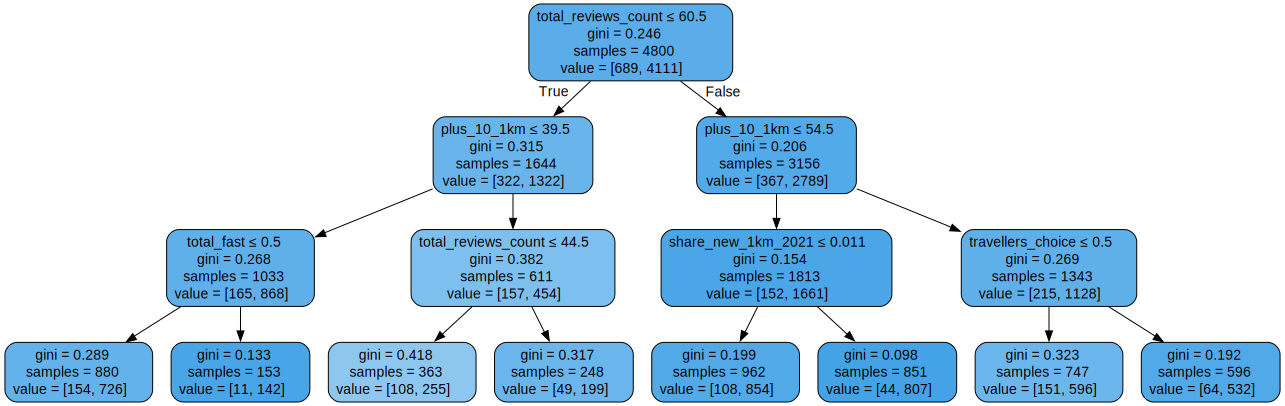

In [38]:
# We need to fill in the null values for the decision tree algorithm.
df_tree_input = df_features[x_cols]
features_with_nulls = df_tree_input.columns[df_tree_input.isnull().any()]
imputer = KNNImputer(n_neighbors=10)  
df_tree_input[features_with_nulls] = imputer.fit_transform(df_tree_input[features_with_nulls])

df_tree_input = pd.get_dummies(df_tree_input)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(df_tree_input, df_features['target'])

dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=df_tree_input.columns,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

For both models, total_reviews_count is the most important feature, while the number of restaurants with at least 10 reviews within 10 km is the second or third most important feature. The decision tree also selected the number of days per week restaurants work, travellers' choice badge, share of new restaurants within 1 km, and whether a restaurant serves fast food.

Some of these features were already visualized earlier. Let's now visualize the rest of the important features.

## Total reviews among restaurants with 30+ reviews

In [39]:
bar_chart_per_country(df_30_plus, 'review_category')

We can see a clear tendency for closure chances to decrease as the number of reviews increases even further.

## Distance counts

In [40]:
df_30_plus['share_new_1km_2021'] = (df_30_plus['new_1km_2021'] + 1)/(df_30_plus['all_1km'] + 90)


def visualize_bins(df_bins, vis_column, bins_min, bins_max, bins_step, vis_title):
    bin_column = vis_column + '_bins'
    df_bins[bin_column] = pd.cut(df_bins[vis_column],
                                 bins=np.linspace(bins_min, bins_max, bins_step)).astype(str)
    df_bins.loc[df_bins[bin_column] == 'nan', bin_column] = str(bins_max) + '+'
    sort_order = list(df_bins.sort_values(vis_column).loc[:, bin_column].unique())
    df_bins.loc[df_bins[vis_column] == bins_min, bin_column] = sort_order[1]
    df_bins[bin_column] = df_bins[bin_column].astype("category")
    df_bins[bin_column] = df_bins[bin_column].cat.set_categories(sort_order)
    horisontal_bar(df_bins.sort_values([bin_column, 'status_binary'], ascending=[False, False]),
                   'status_binary', bin_column, vis_title)
    
visualize_bins(df_30_plus, 'plus_10_1km', 0, 800, 11,
               'Percent of Closed Restaurants, Depending on the Count of Restaurants with 30+ Reviews within 1 km')

Surprisingly, the algorithm chose a feature that only counts restaurants with more than 10 reviews within 10 km over a feature that counts all restaurants. We can see that restaurants that are close to many popular restaurants within 1 km have lower survival chances. About a half of all restaurants have less than 80 restaurants with at least 10 reviews within 1 km and are in the first bin, and the share of closed restaurants is lowest among this group.

In [41]:
visualize_bins(df_30_plus, 'share_new_1km_2021', 0, 0.04, 9,
               'Percent of Closed Restaurants, Depending on the Share of New Restaurants within 1 km')

This feature only counts restaurants opened in 2021 as new, this means only restaurants that opened from January to the first half of May 2021 are considered new. The feature that counts restaurants opened in 2020 and 2021 as new actually made the model's performance worse. This could be because something important has changed since the pandemic.

We can see that more restaurants survive in the areas with more newly opened restaurants. So there are locations where no or few new restaurants open and existing restaurants tend to close, and areas where more new restaurants open and existing restaurants rarely close.

In [42]:
def add_color_share_new(df_color):
    df_color['color'] = 'mediumvioletred'
    df_color.loc[df_color['share_new_1km_2021'] > 0.005, 'color'] = 'gold'
    df_color.loc[df_color['share_new_1km_2021'] > 0.016, 'color'] = 'seagreen'
    return df_color

m_new = folium.Map(location=[62.8, 24.9], zoom_start=6, tiles ='CartoDB Dark_Matter', attr='CartoDB')

df_ni_map = df_30_plus.loc[(df_30_plus['country'] == 'Northern Ireland') &
                           (df_30_plus['latitude'] > 54) &
                           (df_30_plus['longitude'] < -5.4) ]
df_sk_map = df_30_plus.loc[(df_30_plus['country'] == 'Slovakia') &
                           (df_30_plus['latitude'].notnull()) &
                           (df_30_plus['latitude'] > 47)  & (df_30_plus['latitude'] < 50)]
df_bg_map = df_30_plus.loc[(df_30_plus['country'] == 'Bulgaria') &
                           (df_30_plus['latitude'].notnull()) &
                           (df_30_plus['longitude'] > 22)]
df_fi_map = df_30_plus.loc[(df_30_plus['country'] == 'Finland') &
                           (df_30_plus['latitude'].notnull()) &
                           (df_30_plus['latitude'] > 45)]

df_all_map = pd.concat([df_ni_map, df_sk_map, df_bg_map, df_fi_map])

m_new = vis_map(add_color_share_new(df_all_map), m_new)

m_new

The map is centered on Finland, but restaurants from all four countries are displayed.

It was hard not to visualize places with a high share of newly opened restaurants on the map after learning that this is one of the most important features that can be used to predict closure chances for restaurants. Please note that here only restaurants with 30+ reviews as of May 2021 are visualized, while when calculating the share of new restaurants, all the restaurants, regardless of number of reviews, were counted.

We can see that the vast majority of small and medium-sized cities and restaurants in rural areas have average shares of new restaurants and are colored yellow. A few restaurants in rural areas are colored green; these are mostly restaurants that happened to be located near restaurants that opened in the first half of 2021. Almost all restaurants that opened in 2021 didn't get 30 reviews and are not shown on this map.

We can see a few locations with many restaurants where few or no new restaurants opened, like in the center of Londonderry (NI) or in Oulu (FI). In the centers of the big cities, we can see all the three colors, as there are some growing areas where new restaurants open and also areas where new restaurants do not open and more existing restaurants close.

## Atmosphere rating
Of all the ratings calculated by TripAdvisor, only the atmosphere rating turned out to be useful in selecting the surviving restaurants.

In [43]:
bar_chart_per_country(df_30_plus, 'atmosphere')

We can only see expected results for Finland, where restaurants with a high atmosphere rating have a higher survival rate, while for other countries there is no clear pattern. There is no obvious explanation for such a difference between Finland and other countries.

In [44]:
df_30_plus['quick_bites'] = 0
df_30_plus.loc[df_30_plus['top_tags'].str.contains("Quick Bites", na=False), 'quick_bites'] = 1

df_30_plus['fast_food'] = 0
df_30_plus.loc[df_30_plus['cuisines'].str.contains("Fast food", na=False), 'fast_food'] = 1

df_30_plus['total_fast'] = 0
df_30_plus.loc[(df_30_plus['fast_food'] == 1) | (df_30_plus['quick_bites'] == 1), 'total_fast'] = 1

bar_chart_per_country(df_30_plus, 'total_fast')

We can see that in Finland and Bulgaria, the values are very close, while in Northern Ireland and Slovakia, fast food restaurants tend to survive more often. It makes sense, as if a fast food restaurant managed to get 30 reviews on TripAdvisor, that already means it is somewhat successful.

This feature turned out to be more useful than features like "vegetarian friendly" and "gluten free".

# Conclusions
The data turns out to be very noisy, and this is because, in so many cases, restaurant closures do not get reported on TripAdvisor. Restaurant survival could only be explored using a subset of data that excludes restaurants with unclear status.

Users in Northern Ireland use TripAdvisor in a bit different way than in other countries in the dataset, as they more often leave reviews for their local restaurants, while in Slovakia, Bulgaria and Finland, a higher share of reviews comes from tourists.

The dataset doesn't contain enough information to predict which restaurants are going to close, it is only possible to point at restaurants that are slightly less likely or slightly more likely to close. The most important features that help us predict restaurants that are at risk of closure are the total number of reviews, TripAdvisor rating, number of days per week a restaurant is open, share of newly opened restaurants within 1 km, total number of restaurants within 1 km, and whether a restaurant has a travellers' choice badge.

No doubt, so much more exploration can be made with this data, but that is all for this attempt to look at restaurants that continue working and restaurants that close. Thank you for reading this to the end!